# Supplementary figures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
from scipy.stats import spearmanr, ttest_ind, ttest_rel, norm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import ast
import pyranges as pr
import matplotlib.patches as mpatches



from tqdm.auto import tqdm 
tqdm.pandas()

prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config_old/main_pcqtl.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from utils import *
from annotate_clusters import * 
import call_clusters



%config InlineBackend.figure_formats = ['png']
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 7})

In [ ]:
corr_cmap = LinearSegmentedColormap.from_list('corr', [(0, '#69AED1'), (.5, 'white'), (1, '#B83A4B')])

qtl_palette = {'pcQTL only':'#620059', 'eQTL only':'#6FA287', 'Both':'#614591', 'Neither':'grey'}

gtex_tissue_dict = {
    "Adipose_Subcutaneous": "#FFA54F",
    "Adipose_Visceral_Omentum": "#EE9A00",
    "Artery_Tibial": "#FF0000",
    "Cells_Cultured_fibroblasts": "#9AC0CD",
    "Esophagus_Mucosa": "#8B7355",
    "Esophagus_Muscularis": "#CDAA7D",
    "Lung": "#9ACD32",
    "Muscle_Skeletal": "#7A67EE",
    "Nerve_Tibial": "#FFD700",
    "Skin_Not_Sun_Exposed_Suprapubic": "#3A5FCD",
    "Skin_Sun_Exposed_Lower_leg": "#1E90FF",
    "Thyroid": "#008B45",
    "Whole_Blood": "#FF00FF"
}

gtex_tissue_abbrev = ['ADPSBQ',
                      'ADPVSC',
                      'ARTTBL',
                      'CELLS',
                      'ESPMCS',
                      'ESPMSL',
                      'LUNG',
                      'MSCLSK',
                      'NERVET',
                      'SKINNS',
                      'SKINS',
                      'THYROID',
                      'WHLBLD']

gtex_tissue_pal = sns.color_palette(list(gtex_tissue_dict.values()))
gtex_tissue_pal_df = pd.DataFrame(pd.Series(gtex_tissue_dict), columns=['hex']).reset_index(names=['tissue_id'])


### Chromosome example before and after PEER factor residualization


In [3]:
# load in clusters
clusters = load_across_tissues(config, load_clusters_annotated)

In [4]:
# example chr to do 
my_tissue_id = 'Skin_Sun_Exposed_Lower_leg'
chr_num = 17
# load in covatiates
covariates_df = pd.read_csv('{}/{}/{}.v8.covariates.txt'.format(prefix, config['covariates_dir'], my_tissue_id), sep='\t', index_col=0).T
base_covariates = covariates_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'pcr', 'platform', 'sex']]
peer_covariates = covariates_df[[f'InferredCov{i}' for i in range(1,61,1)]]

# load in expression
expression_df = load_expression(config, my_tissue_id)
expression_df = expression_df.set_index('gene_id')[covariates_df.index]


# load in the gene information (for gene-gene distances)
gid_gencode, full_gencode = load_gencode()
gid_gencode_tissue = gid_gencode.loc[expression_df.index]
# get the genes to plot
selected_chr_gene_ids = gid_gencode_tissue[gid_gencode_tissue['chr'] == f'chr{chr_num}'].index.values
selected_chr_gene_names = gid_gencode_tissue[gid_gencode_tissue['chr'] == f'chr{chr_num}']['gene_name']

def get_total_pairs(gid_gencode_tissue):
    # calculate total number of pairs considered for bonferroni correction
    total_pairs = 0
    max_cluster_size=50
    for i in np.arange(1,23,1):
        chr_gene_ids = gid_gencode_tissue[gid_gencode_tissue['chr'] == f'chr{i}'].index.values
        upper_corner_idxs = np.triu(np.ones(len(chr_gene_ids)), k=1)
        excluded_cluster_size_idxs = np.triu(np.ones(len(chr_gene_ids)), k=max_cluster_size)
        total_pairs += upper_corner_idxs.sum()  - excluded_cluster_size_idxs.sum()
    return total_pairs

total_pairs = get_total_pairs(gid_gencode_tissue)

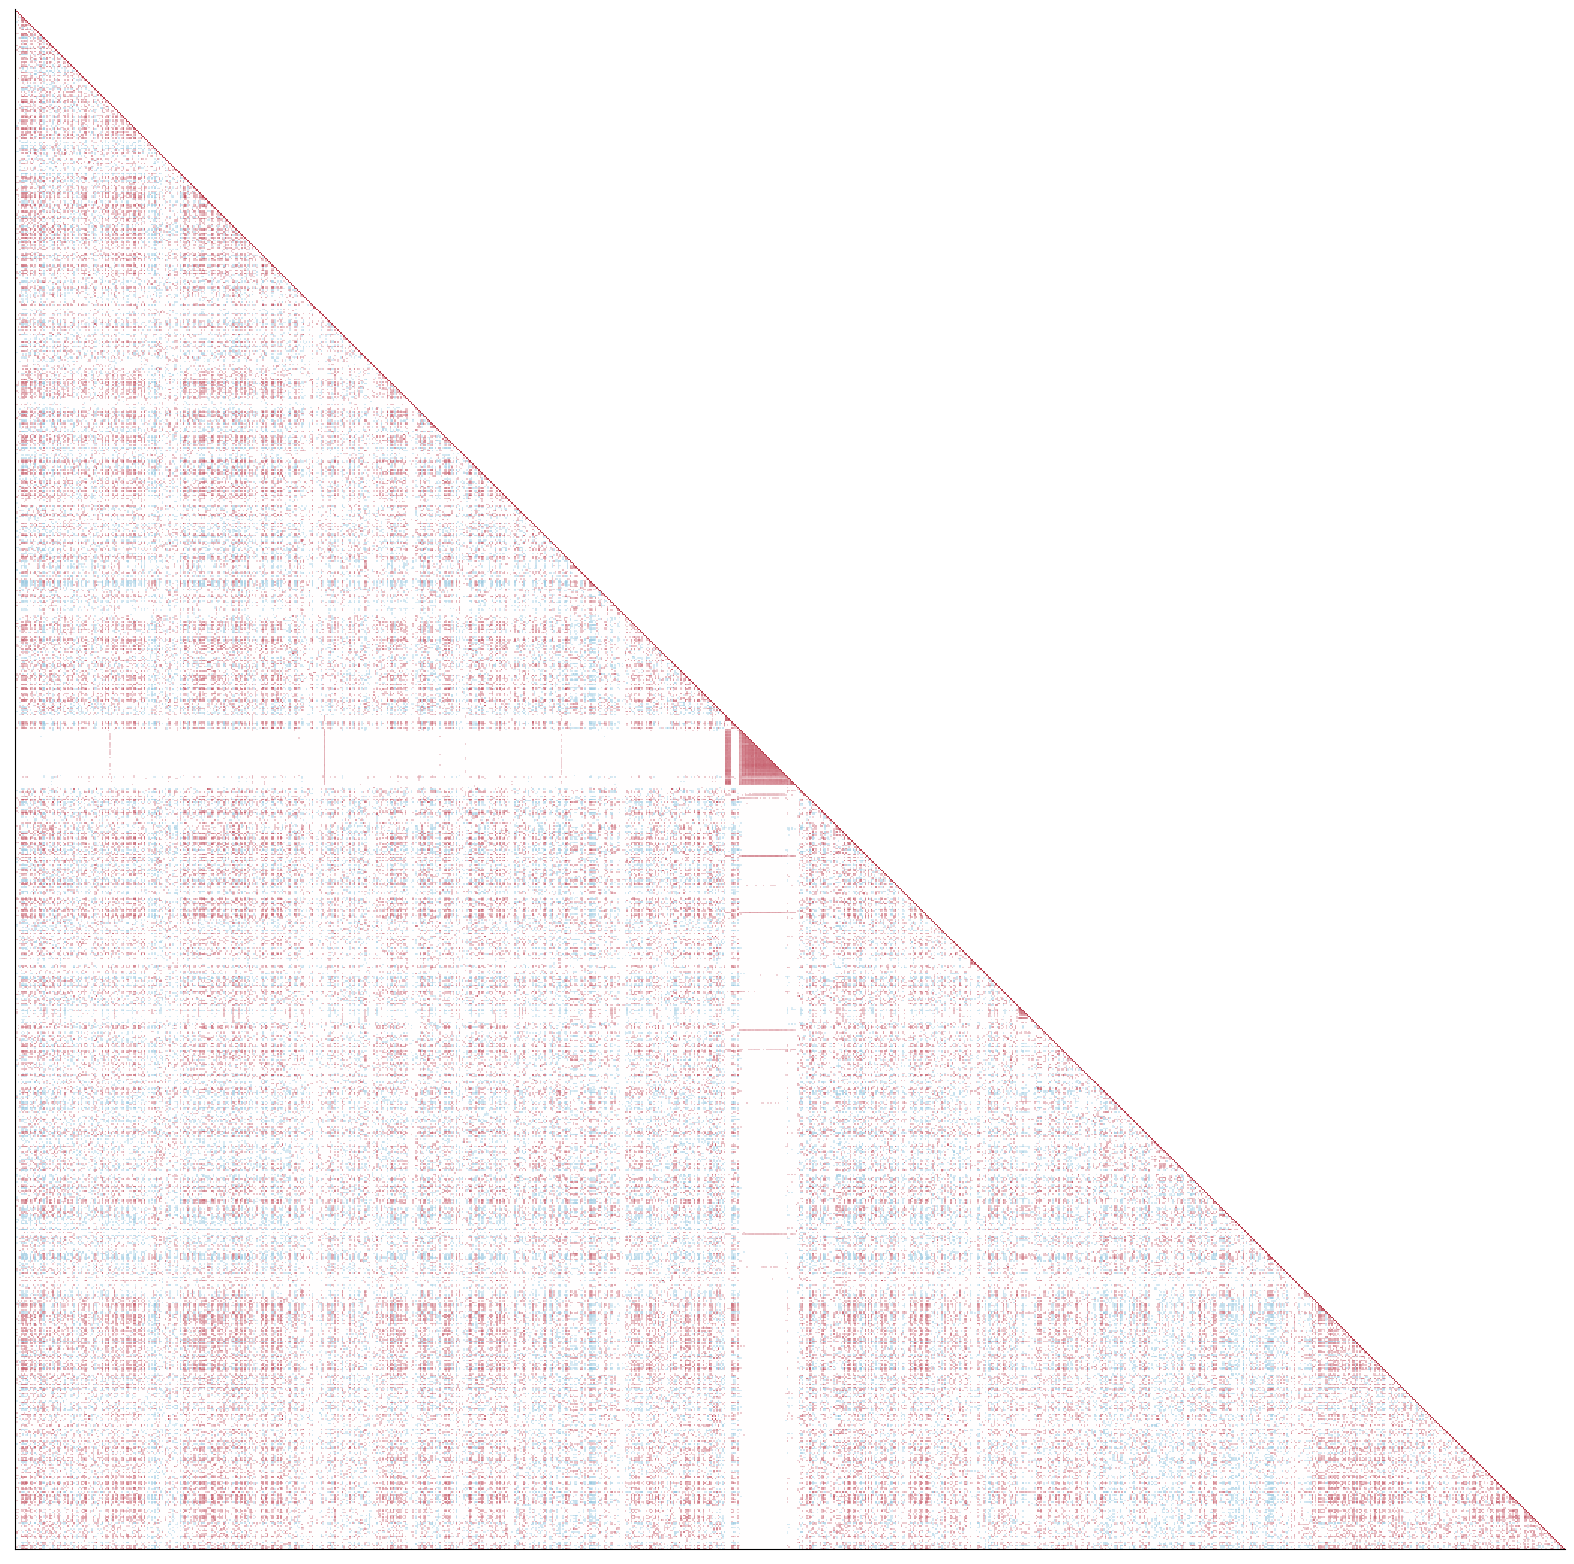

In [ ]:
init_corr, init_pvalue = spearmanr(expression_df.loc[selected_chr_gene_ids], axis=1)

# mask non-sig corrs
init_corr_masked = init_corr.copy()
init_corr_masked[init_pvalue >= (.05/total_pairs)] = 0
init_corr_masked = pd.DataFrame(init_corr_masked, index=selected_chr_gene_names, columns=selected_chr_gene_names)

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(init_corr_masked, mask=np.triu(np.ones_like(init_corr), k=1), cmap=corr_cmap, vmin=-1, vmax=1, ax=ax, cbar_kws={'label':'Spearman Corrleation', 'pad':0}, xticklabels=False, yticklabels=False, cbar=False)

ax.spines[['bottom', 'left']].set_visible(True)
ax.set_xlabel('')
ax.set_ylabel('')
#plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_pre_res_example.pdf", transparent=True)
plt.show()

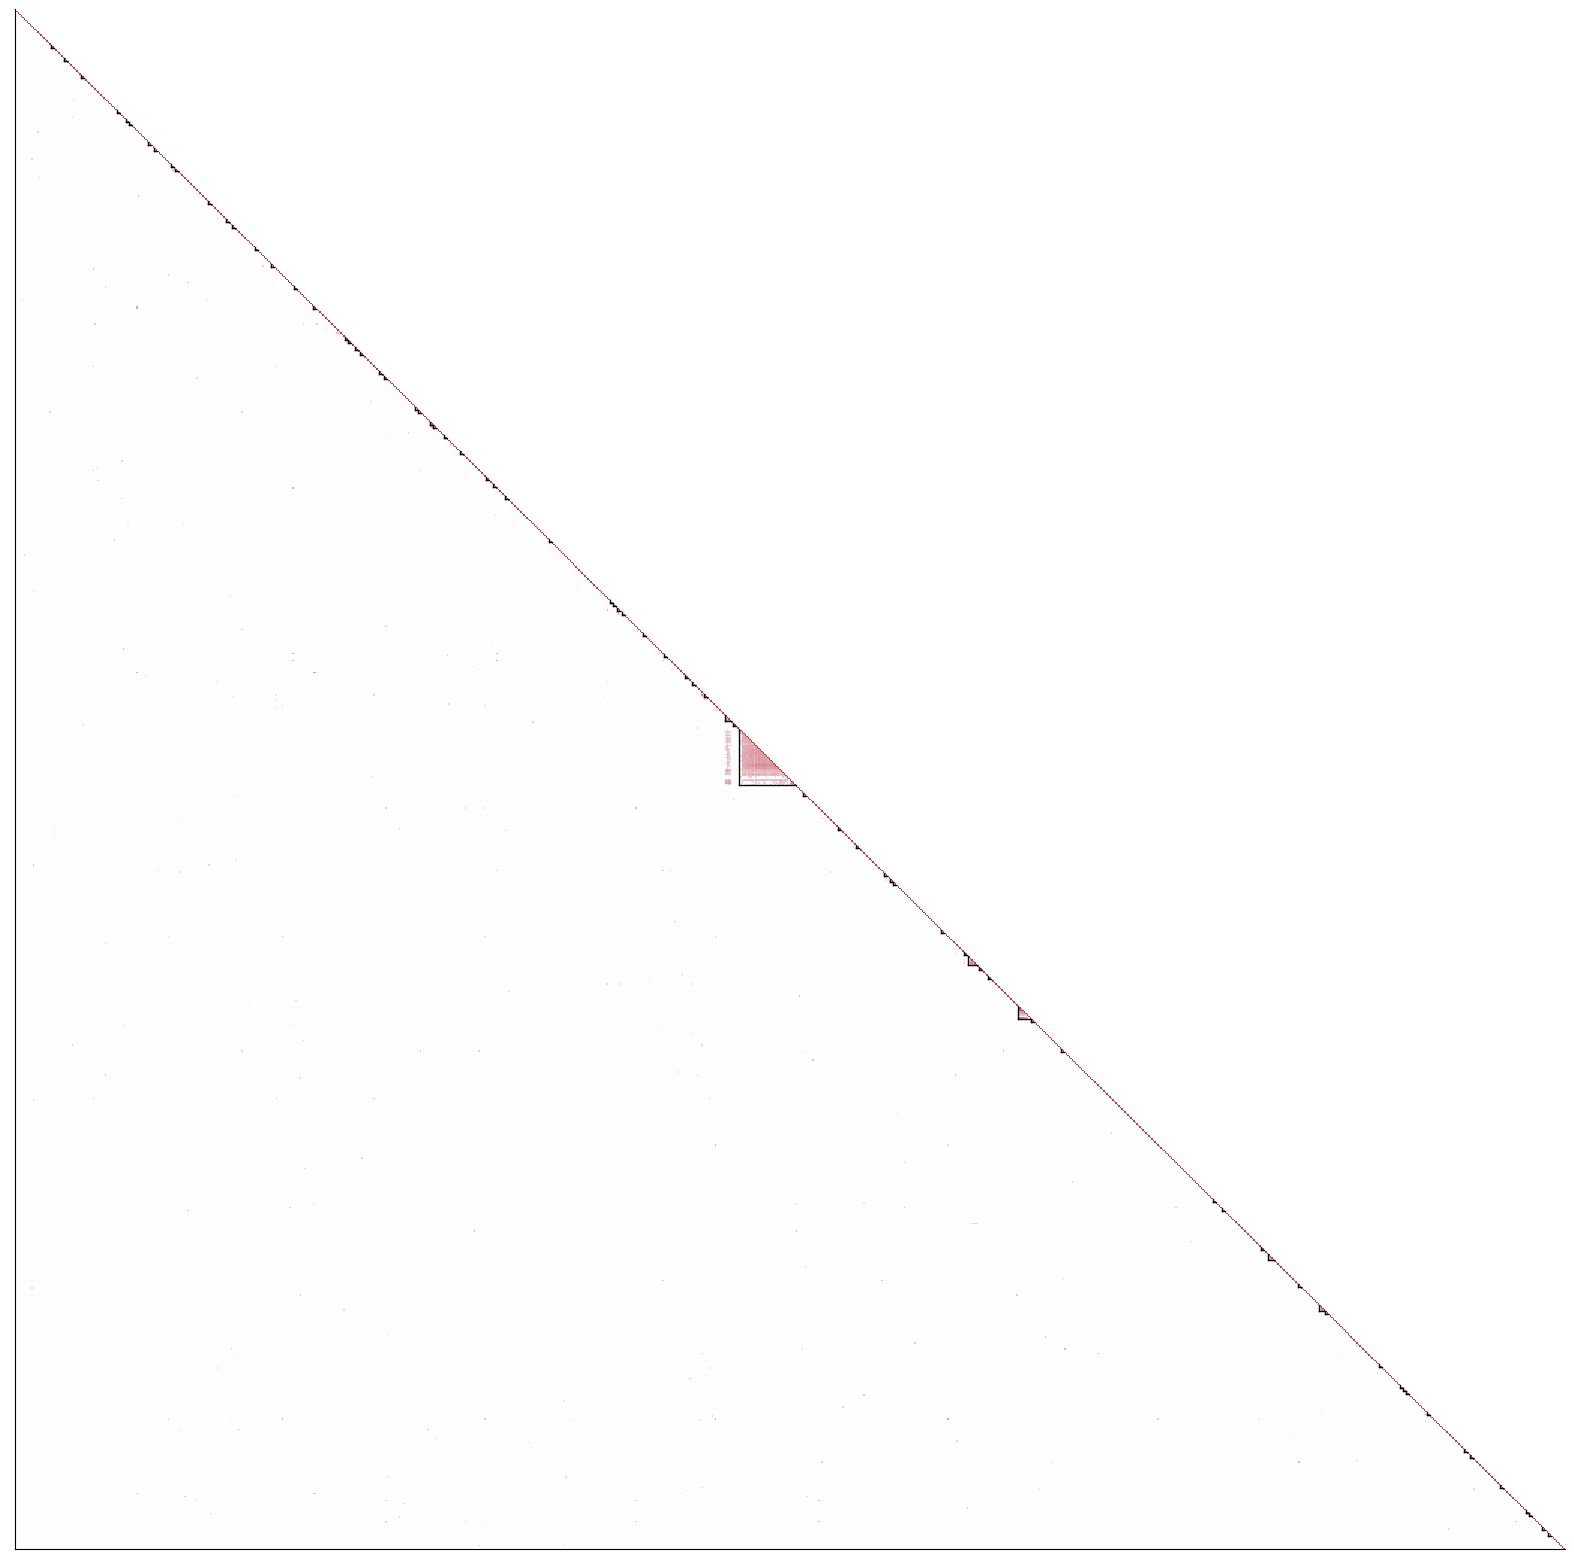

In [ ]:
# function to residualize expression based on two covariate dfs
def two_part_residualize(expression_df, base_covariates_df, additional_covariates_df):
    full_covariates = pd.concat([base_covariates_df, additional_covariates_df], axis=1)
    # residulize the expression 
    residal_exp = calculate_residual(expression_df[full_covariates.index], full_covariates, center=True)
    residal_exp = pd.DataFrame(residal_exp, columns=full_covariates.index, index=expression_df.index)
    return residal_exp


# corr with all 60 peers removed
peer_residual_exp = two_part_residualize(expression_df, base_covariates, peer_covariates)
corrected_corr, corrected_pvalue = spearmanr(peer_residual_exp.loc[selected_chr_gene_ids], axis=1)

# mask non-sig corrs
corrected_corr_masked = corrected_corr.copy()
corrected_corr_masked[corrected_pvalue >= (.05/total_pairs)] = 0
corrected_corr_masked = pd.DataFrame(corrected_corr_masked, index=selected_chr_gene_names, columns=selected_chr_gene_names)

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrected_corr_masked, mask=np.triu(np.ones_like(corrected_corr), k=1), cmap=corr_cmap, vmin=-1, vmax=1, ax=ax, cbar_kws={'label':'Spearman Corrleation', 'pad':0}, xticklabels=False, yticklabels=False, cbar=False)

# add in clusters
for idx, cluster in clusters[(clusters['Chromosome']==chr_num)&(clusters['tissue_id']==my_tissue_id)].iterrows():
    cluster_idxs = np.concatenate([np.where(selected_chr_gene_ids==cluster['Transcripts'].split(',')[i])[0] for i in range(cluster['N_genes'])])
    if len(cluster_idxs) > 0:
        # Calculate rectangle properties
        x = cluster_idxs[0]
        y = cluster_idxs[0]
        width = np.ptp(cluster_idxs) + 1
        height = np.ptp(cluster_idxs) + 1
        ax.plot([x, x + width], [y + height, y + height], color='k', linewidth=1)
        ax.plot([x, x], [y, y + height], color='k', linewidth=1)
    
ax.spines[['bottom', 'left']].set_visible(True)
ax.set_xlabel('')
ax.set_ylabel('')
#plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_post_res_example.pdf", transparent=True)
plt.show()

### correlation split by distance as PEER factors are residualized

In [27]:
full_genocde = pr.read_gtf("/home/klawren/oak/pcqtls/data/references/gencode.v26.annotation.gtf.gz", as_df=True)
genes = full_genocde[full_genocde['Feature'] == 'gene']
genes['tss_start'] = np.where(genes['Strand'] == '+', genes['Start'], genes['End'])
strand_dict = genes.set_index('gene_id')['Strand'].to_dict()
tss_dict = genes.set_index('gene_id')['tss_start'].to_dict()

/local/scratch/klawren/slrmtmp.48343185/ipykernel_50921/4174605719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['tss_start'] = np.where(genes['Strand'] == '+', genes['Start'], genes['End'])


In [ ]:
# Calculate distances and add to the significant_corr DataFrame
def calculate_distance(row):
    gene1 = row['gene_id_1']
    gene2 = row['gene_id_2']
    tss1 = tss_dict.get(gene1)
    tss2 = tss_dict.get(gene2)
    return abs(tss1 - tss2) 

def get_corr_pairs(expression_df, gene_ids, total_pairs):
    corr, pvalue = spearmanr(expression_df.loc[gene_ids], axis=1)
    # mask non-sig corrs
    corr_masked = corr.copy()
    corr_masked[pvalue >= (.05/total_pairs)] = 0
    corr_masked = pd.DataFrame(corr_masked, index=selected_chr_gene_ids, columns=selected_chr_gene_ids)
    corr_pairs = corr_masked.stack().reset_index()
    corr_pairs.columns = ['gene_id_1', 'gene_id_2', 'corr']
    corr_pairs = corr_pairs[corr_pairs['gene_id_1'] !=corr_pairs['gene_id_2']]
    # only keep signifignat ones
    sig_corr_pairs = corr_pairs[corr_pairs['corr']!=0].copy()
    
    # add tss to tss distance
    sig_corr_pairs.loc[:, 'distance'] = sig_corr_pairs.apply(calculate_distance, axis=1)
    return sig_corr_pairs

In [ ]:
my_tissue_id = 'Cells_Cultured_fibroblasts'

# load in covatiates
covariates_df = pd.read_csv('{}/{}/{}.v8.covariates.txt'.format(prefix, config['covariates_dir'], my_tissue_id), sep='\t', index_col=0).T
base_covariates = covariates_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'pcr', 'platform', 'sex']]
peer_covariates = covariates_df[[f'InferredCov{i}' for i in range(1,61,1)]]

# load in expression
expression_df = load_expression(config, my_tissue_id)
expression_df = expression_df.set_index('gene_id')[covariates_df.index]

# get the genes on this chr only
gid_gencode_tissue = gid_gencode.loc[expression_df.index]

chr_corr_pairs_list=[]
for chr_num in tqdm(range(1, 23)):
    selected_chr_gene_ids = gid_gencode_tissue[gid_gencode_tissue['chr'] == f'chr{chr_num}'].index.values
    for num_peers in [0, 15, 30, 45, 60]:
        residual_exp = two_part_residualize(expression_df, base_covariates, peer_covariates.iloc[:, :num_peers])
        chr_corr_pairs_list.append(get_corr_pairs(residual_exp, selected_chr_gene_ids, total_pairs))

chr_corr_pairs = pd.concat(chr_corr_pairs_list, keys=np.tile([0, 15, 30, 45, 60], 22), names=['num_peer'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [02:05<00:00,  5.69s/it]


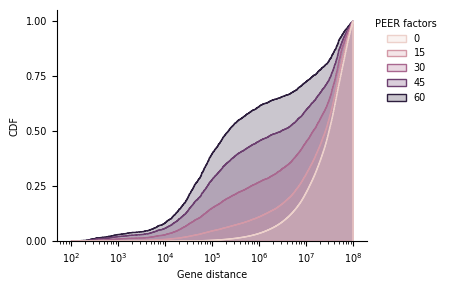

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.histplot(data=chr_corr_pairs, x='distance', hue='num_peer', stat='density', cumulative=True, bins=np.arange(2, 8, .01), element='step', log_scale=True, common_norm=False)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Gene distance')
ax.set_ylabel('CDF')
ax.set_yticks([0, .25, .5, .75, 1])

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='PEER factors')
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_res_cdf.pdf", transparent=True)
plt.show()

In [ ]:
# numbers for the writing
print(chr_corr_pairs.loc[0]['distance'].median()/1e6)
print(chr_corr_pairs.loc[60]['distance'].median()/1e3)

40.017897
286.234


### Clusters null with shuffled samples 

In [ ]:

tissue_cluster_df = clusters[clusters['tissue_id'] == my_tissue_id]
# load full expression (not just cluster expression)
tissue_full_expression_df = load_expression(config, my_tissue_id)


# cluster density on per chrom basis for the actual clusters
cluster_density = []
for i in np.arange(1,23,1):
    chr_gene_ids = tissue_full_expression_df[tissue_full_expression_df['#chr'] == f'chr{i}']['gene_id']
    cluster_density.append(tissue_cluster_df[tissue_cluster_df['Chromosome'] == i]['N_genes'].sum()/len(chr_gene_ids))


# randomly resample the dataframe to shuffle the gene locations
# reasign the same 'gene_ids' to match the expression df
# on all chrs takes ~ 10min
final_residual_exp = two_part_residualize(expression_df, base_covariates, peer_covariates)
shuffled_expression = final_residual_exp.sample(len(final_residual_exp))
shuffled_expression.index = final_residual_exp.index
null_cluster_df = call_clusters.get_clusters(tissue_full_expression_df, shuffled_expression, my_tissue_id)

# cluster density on per chrom basis for the null clusters
cluster_density_null = []
for i in np.arange(1,23,1):
    chr_gene_ids = tissue_full_expression_df[tissue_full_expression_df['#chr'] == f'chr{i}']['gene_id']
    cluster_density_null.append(null_cluster_df[null_cluster_df['Chromosome'] == i]['N_genes'].sum()/len(chr_gene_ids))

running call clusters
Working on chr1
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Found 1 clusters
Working on chr2
calcuated correlations
Found 0 clusters
Working on chr3
calcuated correlations
Found 0 clusters
Working on chr4
calcuated correlations
Found 0 clusters
Working on chr5
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Found 1 clusters
Working on chr6
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Found 1 clusters
Working on chr7
calcuated correlations
Found 0 clusters
Working on chr8
calcuated correlations
Found 0 clusters
Working on chr9
calcuated correlations
Found 0 clusters
Working on chr10
calcuated correlations
Found 0 clusters
Working on chr11
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Found 1 clusters
Working on chr12
calcuated correlations
Found 0 clusters
Working on chr13
calcuated correlations
Found 0 clusters
Working on chr14
calcuated correlations
Found 0 clusters
Working on chr15
calcuated correlations
Found 0 clusters
Working on chr16
calcuated correlations
Found 0 clusters
Working on chr17
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Found 1 clusters
Working on chr18
calcuated correlations
Found 0 clusters
Working on chr19
calcuated correlations


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Found 1 clusters
Working on chr20
calcuated correlations
Found 0 clusters
Working on chr21
calcuated correlations
Found 0 clusters
Working on chr22
calcuated correlations
Found 0 clusters


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/seaborn/categorical.py:3398: UserWarning: 68.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/seaborn/categorical.py:3398: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/seaborn/categorical.py:3398: UserWarning: 77.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


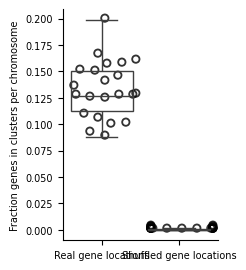

In [ ]:
cluster_density_df = pd.DataFrame({'Real gene locations': cluster_density, 'Shuffled gene locations':cluster_density_null})

fig, ax = plt.subplots(figsize=(2, 3))
sns.swarmplot(cluster_density_df,color='k', zorder=0, marker="$\circ$", ec="face", s=10, alpha=.8, ax=ax)
sns.boxplot(cluster_density_df, 
                 showcaps=True,boxprops={'facecolor':'None'},
                 showfliers=False, whiskerprops={'linewidth':1}, ax=ax)
ax.set_ylabel('Fraction genes in clusters per chromosome')
ax.spines[['top','right']].set_visible(False)
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_cluster_null.pdf", transparent=True)
plt.show()

### cross mappable clusters

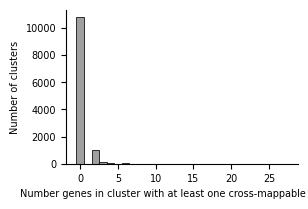

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))
sns.histplot(clusters, x='num_cross_map', 
             discrete=True, color='grey')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Number genes in cluster with at least one cross-mappable XX-mer")
ax.set_ylabel("Number of clusters")
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_cross_map.pdf", transparent=True)

plt.show()


### cluster sharing across tissues

In [8]:
tissue_sharing = clusters.groupby('cluster_id').agg({'tissue_id':'unique'})

def get_pretty_tissue_id(tissue_id_list):
    return [tissue_id.replace('_', ' ') for tissue_id in tissue_id_list]
tissue_sharing['tissue_id_pretty'] = tissue_sharing['tissue_id'].apply(get_pretty_tissue_id)

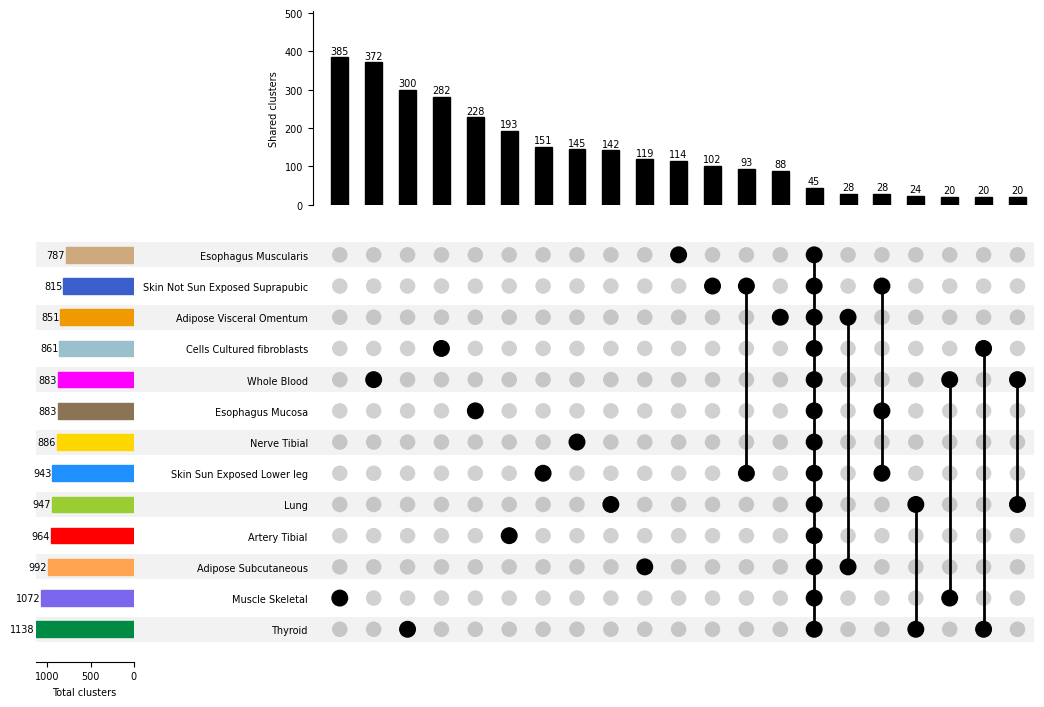

In [ ]:
upset = up.UpSet(up.from_memberships(tissue_sharing['tissue_id_pretty']), subset_size='count', min_subset_size=20, show_counts=True, 
                 sort_by="cardinality", facecolor="black", totals_plot_elements=3)


# style the instersection plot
plot_result = upset.plot()
intersection_plot = plot_result["intersections"]
intersection_plot.set_ylabel("Shared clusters")
intersection_plot.set_xlim(-.8, intersection_plot.get_xlim()[1])
intersection_plot.set_ylim(0, intersection_plot.get_ylim()[1]+100)
intersection_plot.grid(False)

# style the totals plot
totals_plot = plot_result["totals"]
#totals_plot.set_xlim((1200, 0))
totals_plot.grid(False)
totals_plot.set_xlabel("Total clusters")
# change totals plot colors to match gtex tissues
gtex_tissue_pal_df['tissue_id_pretty'] = gtex_tissue_pal_df['tissue_id'].str.replace('_', ' ')
for bar, label in zip(plot_result["totals"].patches, totals_plot.get_yticklabels()):
    bar.set_color(gtex_tissue_pal_df[gtex_tissue_pal_df['tissue_id_pretty'] == label.get_text()]['hex'].iloc[0])  # Set the color based on the palette

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_cluster_tissues_sharing_upset.pdf", transparent=True)
plt.show()

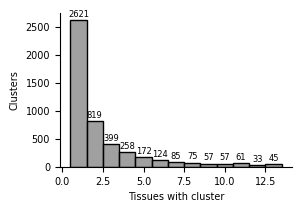

In [ ]:
tissue_sharing['num_tissues'] = tissue_sharing['tissue_id'].apply(len)
fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(tissue_sharing, x='num_tissues', discrete=True, ax=ax, color='grey')
ax.bar_label(ax.containers[0], fontsize=6, padding=1)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Tissues with cluster")
ax.set_ylabel("Clusters")
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_cluster_tissues_sharing_counts.pdf", transparent=True)
plt.show()

### example clusters

In [ ]:
def plot_cluster(example_cluster, cbar=False):
    # gene gene ids sorted by tss start
    sorted_cluster = gid_gencode.loc[example_cluster['cluster_id'].split('_')].sort_values('tss_start')
    sorted_gene_ids = sorted_cluster.index.values
    # get normed expression 
    expression = load_cluster_expression(config, example_cluster['Tissue'])
    cluster_expression = expression[(expression['cluster_id']==example_cluster['cluster_id'])].set_index('egene_id').loc[sorted_gene_ids]
    # get correlation of expression
    sample_ids = cluster_expression.columns[cluster_expression.columns.str.contains('GTEX')]
    cluster_corr, cluster_pvalue = spearmanr(cluster_expression[sample_ids], axis=1)
    # make df wtih readable gene names
    cluster_corr = pd.DataFrame(cluster_corr, index=sorted_cluster['gene_name'].values, columns=sorted_cluster['gene_name'].values)

    # make corr plot
    fig_size = int(len(cluster_corr)/4)
    print(fig_size)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    sns.heatmap(cluster_corr, mask=np.triu(np.ones_like(cluster_corr), k=1),
                cmap=corr_cmap, vmin=-1, vmax=1, ax=ax, 
                cbar_kws={'label':'Spearman Corrleation'}, 
                xticklabels=True, yticklabels=True, cbar=cbar)
    ax.tick_params("y", rotation=0) 
    return ax
     

9


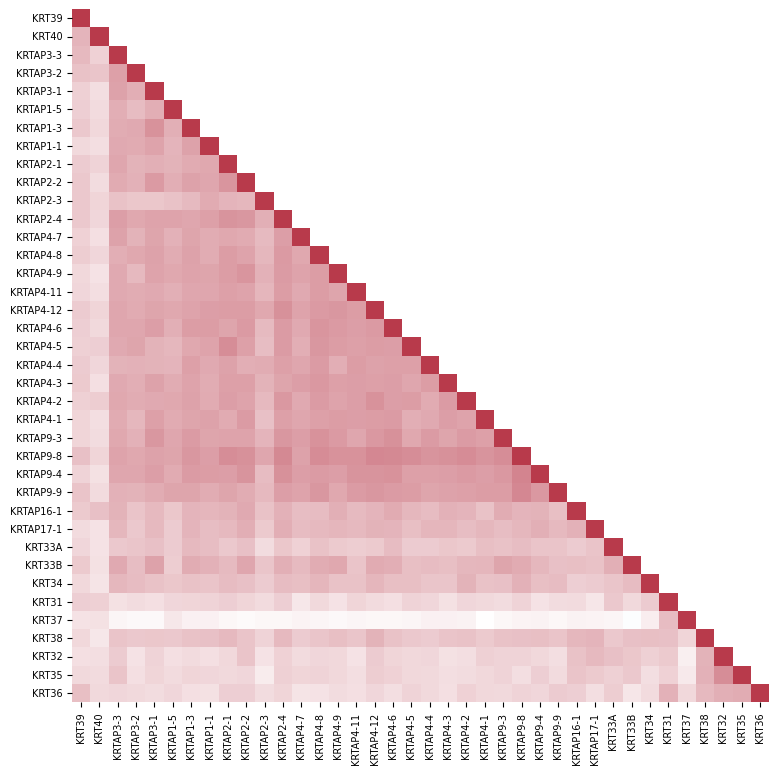

In [ ]:
# keratin cluster
plot_cluster(clusters.iloc[9757])
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_cluster_example_keratin.pdf", transparent=True)
plt.show()

In [ ]:
shared_cluster_id = 'ENSG00000105808.17_ENSG00000168255.19_ENSG00000170667.14_ENSG00000205238.9_ENSG00000228049.7_ENSG00000267368.1'

1


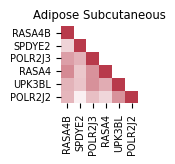

1


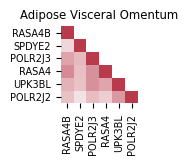

1


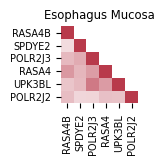

1


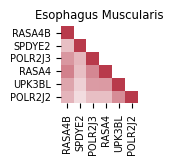

1


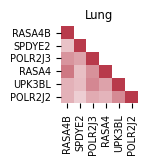

1


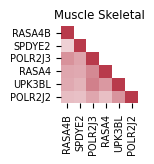

1


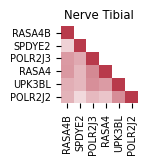

1


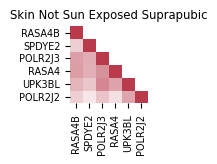

1


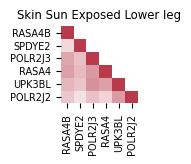

1


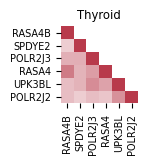

In [ ]:
for idx, cluster in clusters[clusters['cluster_id']==shared_cluster_id].iterrows():
    ax = plot_cluster(cluster)
    ax.set_title(cluster['Tissue'].replace('_', ' '))
    plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_cluster_example_shared_{}.pdf".format(cluster['Tissue']), transparent=True)
    plt.show()

### cluster distance before resampling

In [ ]:
# get min distance between any two genes in the cluster
clusters['gene_id_1'] = clusters['cluster_id'].str.split('_')
clusters['gene_id_2'] = clusters['cluster_id'].str.split('_')
clusters_exploded = clusters.explode('gene_id_1').explode('gene_id_2').reset_index()
clusters_exploded = clusters_exploded[clusters_exploded['gene_id_1'] != clusters_exploded['gene_id_2']]
clusters_exploded.loc[:, 'distance'] = clusters_exploded.apply(calculate_distance, axis=1)

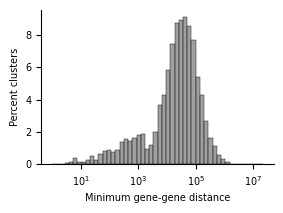

In [ ]:
clusters_min_distance = clusters_exploded.groupby(['cluster_id', 'tissue_id']).agg({'distance':min}).reset_index()

fig, ax = plt.subplots(figsize=(3,2))
sns.histplot(clusters_min_distance, x='distance', bins=50, log_scale=True, color='grey', stat='percent')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Minimum gene-gene distance")
ax.set_ylabel("Percent clusters")
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_cluster_distance.pdf", transparent=True)
plt.show()

### PC correlations to one another

In [ ]:
pc_df = load_pc(config, my_tissue_id).reset_index(drop=True)

# local pc correlations to one another 
pc_corr_values = []
for chr_id, pc_chr_df in pc_df.groupby('#chr'):
    pc_corr, pc_pvalue = spearmanr(pc_chr_df[pc_chr_df.columns[pc_chr_df.columns.str.contains('GTEX')]], axis=1)
    pc_corr_df = pd.DataFrame(pc_corr)
    upper_triangle_indices = np.triu_indices_from(pc_corr_df, k=1)  # k=1 excludes the diagonal
    upper_triangle_values = pc_corr_df.values[upper_triangle_indices]
    pc_corr_values.extend(upper_triangle_values.tolist())


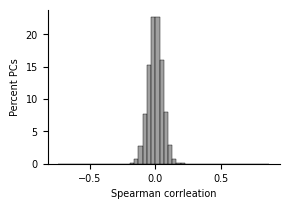

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))
sns.histplot(pc_corr_values, bins=50, color='grey', stat='percent')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Spearman corrleation")
ax.set_ylabel("Percent PCs")
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_local_pc_corr.pdf", transparent=True)
plt.show()

### pc varience for non cluster genes

In [ ]:
# load in expression and covariates data
covariates_df = pd.read_csv('{}/{}/{}.v8.covariates.txt'.format(prefix, config['covariates_dir'], my_tissue_id), sep='\t', index_col=0).T
expression_df = load_expression(config, my_tissue_id)

residal_exp = calculate_residual(expression_df[covariates_df.index], covariates_df, center=True)
residal_exp = pd.DataFrame(residal_exp, columns=covariates_df.index, index=expression_df['gene_id'])
residal_exp.reset_index(inplace=True)


In [ ]:
# faster version
def get_global_pc_variances(pc_df, residal_exp):
    sample_ids = pc_df.columns[pc_df.columns.str.contains('GTEX')]
    num_pc = len(pc_df)
    num_expression = len(residal_exp)
    global_variences = np.zeros((num_pc, num_expression))

    # Convert relevant DataFrames to numpy arrays for faster access
    pc_values_array = pc_df[sample_ids].astype('float').to_numpy()
    expression_values_array = residal_exp[sample_ids].astype('float').to_numpy()

    # Center the values by subtracting the mean
    pc_means = pc_values_array.mean(axis=1, keepdims=True)
    expression_means = expression_values_array.mean(axis=1, keepdims=True)

    # Compute standard deviations
    pc_std = pc_values_array.std(axis=1, keepdims=True)
    expression_std = expression_values_array.std(axis=1, keepdims=True)

    # Compute the global variances
    for pc_idx in tqdm(range(num_pc), total=num_pc):
        for expression_idx in range(num_expression):
            # Covariance calculation (using centered values)
            covariance = np.sum((pc_values_array[pc_idx] - pc_means[pc_idx]) * (expression_values_array[expression_idx] - expression_means[expression_idx]))
            r_num = covariance
            r_den = pc_std[pc_idx] * expression_std[expression_idx] * (len(sample_ids) - 1)  # normalization factor

            # Compute the squared correlation coefficient
            if r_den != 0:
                r_squared = (r_num / r_den) ** 2
            else:
                r_squared = 0  # if standard deviation is zero, set to 0 (no correlation)

            global_variences[pc_idx, expression_idx] = r_squared
    return global_variences

### genome wide var expalined by local pc vs by peers

In [ ]:
# var exaplined by local pcs on residualized expression
global_variences = []
for chr_id, chr_pc_df in pc_df.groupby('#chr'):
    print(chr_id)
    chr_global_variences = get_global_pc_variances(chr_pc_df, residal_exp)
    # mask for if the value is in a cluster
    in_cluster_mask = np.zeros(chr_global_variences.shape)
    for i in range(len(residal_exp)):
        expression_row = residal_exp.iloc[i]
        in_cluster_mask[:,i] = chr_pc_df['gene_id'].str.contains(expression_row['gene_id'])
    global_variences.append(pd.DataFrame({'var_explained':chr_global_variences.flatten()*100, 'gene_type':in_cluster_mask.flatten()}))

global_variences_df = pd.concat(global_variences)


chr1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [01:56<00:00,  1.95it/s]


chr10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:29<00:00,  2.02it/s]


chr11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:45<00:00,  2.05it/s]


chr12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [01:01<00:00,  1.94it/s]


chr13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:16<00:00,  1.93it/s]


chr14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:34<00:00,  1.96it/s]


chr15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:31<00:00,  1.93it/s]


chr16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:36<00:00,  1.95it/s]


chr17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:12<00:00,  1.87it/s]


chr18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:11<00:00,  2.06it/s]


chr19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [01:05<00:00,  2.01it/s]


chr2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:12<00:00,  1.86it/s]


chr20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:24<00:00,  2.05it/s]


chr21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.01it/s]


chr22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:19<00:00,  1.94it/s]


chr3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


chr4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:47<00:00,  1.98it/s]


chr5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:34<00:00,  1.94it/s]


chr6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:46<00:00,  1.98it/s]


chr7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:58<00:00,  1.96it/s]


chr8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:27<00:00,  1.94it/s]


chr9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:35<00:00,  2.01it/s]


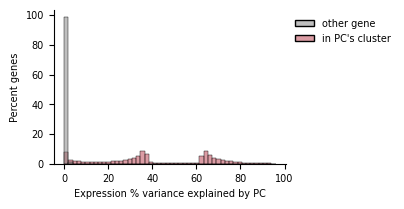

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))

sns.histplot(global_variences_df, x='var_explained', bins=50, hue='gene_type', common_norm=False, stat='percent', palette=['grey', '#B83A4B'])

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Expression % variance explained by PC')
ax.set_ylabel('Percent genes')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title='', labels=['other gene', "in PC's cluster"], frameon=False)
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_local_pc_var_histplot.pdf", transparent=True)
plt.show()


### PCQTL null with shuffled expression

In [ ]:
from tensorqtl import susie, genotypeio, read_phenotype_bed
from get_pcs import get_pc_bed

In [ ]:

# PLINK reader for genotypes
plink_prefix_path = '/home/klawren/oak/pcqtls/data/processed/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.SHAPEIT2_phased.MAF01'

pgr = genotypeio.PlinkReader(plink_prefix_path)
genotype_df = pgr.load_genotypes()

variant_df = pgr.bim.set_index('snp')[['chrom', 'pos']]

Mapping files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.44s/it]


In [ ]:
pc_phenotype_df, pc_phenotype_pos_df = read_phenotype_bed('{}/{}/{}.pcs.bed'.format(prefix, config['pc_output_dir'], my_tissue_id))
phenotype_df, phenotype_pos_df = read_phenotype_bed('{}/{}/{}.v8.normalized_residualized_expression.cluster_genes.bed'.format(prefix, config['filtered_expression_output_dir'], my_tissue_id))
covariates_df = pd.read_csv('{}/{}/{}.v8.covariates.txt'.format(prefix, config['covariates_dir'], my_tissue_id), sep='\t', index_col=0).T
tissue_cluster_df = load_cluster(config, my_tissue_id)

In [ ]:
# create shuffled expression and pcs
reordered = []
for idx, row in phenotype_df.iterrows():
    reordered.append(row.sample(frac=1).set_axis(phenotype_df.columns))
shuffled_e_phenotype_df = pd.DataFrame(reordered)

# get shuffled expression to right format
shuff_e_expression_df = pd.merge(phenotype_pos_df, shuffled_e_phenotype_df, left_on='gene_id', right_index=True).reset_index()
shuff_e_expression_df.rename(columns={'chr':'#chr'}, inplace=True)

# get pcs from shuffled expression
shuff_pc_expression_df = get_pc_bed(tissue_cluster_df, shuff_e_expression_df, covariates_df)
shuff_pc_phenotype_df = shuff_pc_expression_df[shuff_pc_expression_df.columns[3:]].set_index('gene_id')

Dropped 0 rows due to inf


In [ ]:
# map e and pc qlts from shuffled expression 

shuff_e_susie_summary, shuff_e_susie_res = susie.map(genotype_df, variant_df, 
                        shuffled_e_phenotype_df, 
                        phenotype_pos_df,
                        covariates_df, 
                        summary_only=False)

shuff_e_susie_summary.to_csv('/home/klawren/oak/pcqtls/temp/shuff_e_susie_summary.txt', sep='\t')

SuSiE fine-mapping
  * 483 samples
  * 1872 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 1872/1872
  * fine-mapping
    processing phenotype 1872/1872
  Time elapsed: 23.10 min
done.


In [ ]:
shuff_pc_susie_summary, shuff_pc_susie_res = susie.map(genotype_df, variant_df, 
                        shuff_pc_phenotype_df, 
                        pc_phenotype_pos_df,
                        covariates_df, 
                        summary_only=False)
shuff_pc_susie_summary.to_csv('/home/klawren/oak/pcqtls/temp/shuff_pc_susie_summary.txt', sep='\t')

SuSiE fine-mapping
  * 483 samples
  * 1872 phenotypes
  * 68 covariates
  * 10770860 variants
  * cis-window: ±1,000,000
  * checking phenotypes: 1872/1872
  * fine-mapping
    processing phenotype 1872/1872
  Time elapsed: 22.75 min
done.


In [ ]:
orig_e_susie_summary = load_e_susie(config, my_tissue_id)
orig_pc_susie_summary = load_pc_susie(config, my_tissue_id)

In [ ]:
def get_frac_with_signal(susie_summary, total_signals = len(phenotype_df)):
    return susie_summary['phenotype_id'].nunique()/total_signals

def get_num_cs(susie_summary):
    return len(susie_summary.groupby(['phenotype_id', 'cs_id']).nunique())

cs_counts = pd.DataFrame({'shuffled':['shuffled', 'shuffled', 'original', 'original'], 
              'type':['eqtl', 'pcqtl', 'eqtl', 'pcqtl'], 
              'num_cs':[get_num_cs(shuff_e_susie_summary), get_num_cs(shuff_pc_susie_summary), get_num_cs(orig_e_susie_summary), get_num_cs(orig_pc_susie_summary)],
              'frac_signal':[get_frac_with_signal(shuff_e_susie_summary), get_frac_with_signal(shuff_pc_susie_summary), get_frac_with_signal(orig_e_susie_summary), get_frac_with_signal(orig_pc_susie_summary)]})


In [ ]:
cs_counts

,shuffled,type,num_cs,frac_signal
0,shuffled,eqtl,20,0.010684
1,shuffled,pcqtl,18,0.009615
2,original,eqtl,1809,0.665598
3,original,pcqtl,1673,0.612714


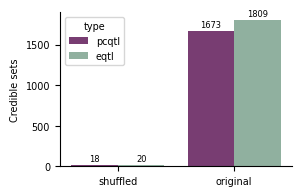

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))

sns.barplot(cs_counts, ax=ax, y='num_cs', x='shuffled', hue='type', hue_order=['pcqtl','eqtl'], palette=[qtl_palette['pcQTL only'], qtl_palette['eQTL only']], alpha=.8)
ax.set_ylabel('Credible sets')
ax.set_xlabel('')
ax.spines[['top', 'right']].set_visible(False)
ax.bar_label(ax.containers[0], fontsize=6, padding=1)
ax.bar_label(ax.containers[1], fontsize=6, padding=1)

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_qtl_null.pdf", transparent=True)
plt.show()

### discoveries by PC number

In [17]:
susie_annotated = load_across_tissues(config, load_susie_annotated)
pcs = load_across_tissues(config, load_pc)

In [20]:
pcs['phenotype_id'] = pcs['gene_id']
annotate_pc_order(pcs)

susie_annotated['phenotype_id_tissue'] = susie_annotated['phenotype_id'] + '-' + susie_annotated['tissue_id']
pcs['phenotype_id_tissue'] = pcs['phenotype_id'] + '-' + pcs['tissue_id']
pcs['has_cs'] = pcs['phenotype_id_tissue'].isin(susie_annotated['phenotype_id_tissue'])

# fraction phenotypes of each type that have a credible set
pc_cs_by_order = pcs.groupby(['tissue_id', 'pc_order']).agg({'has_cs':'mean'}).reset_index()

/local/scratch/klawren/slrmtmp.48343185/ipykernel_21200/2439975531.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pcs['phenotype_id'] = pcs['gene_id']
/home/klawren/oak/pcqtls/workflow/scripts/notebook_helper_functions.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pc_df['pc_num'] = pc_df['phenotype_id'].str.split('_pc').str[-1].astype(int)
/home/klawren/oak/pcqtls/workflow/scripts/notebook_helper_functions.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

/local/scratch/klawren/slrmtmp.48323884/ipykernel_16676/4292245301.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(pc_cs_by_order, x='pc_order', y='has_cs', ax=ax, palette=sns.color_palette('light:{}_r'.format(qtl_palette['pcQTL only']), n_colors=4), order=['first', 'middle', 'last'])
/local/scratch/klawren/slrmtmp.48323884/ipykernel_16676/4292245301.py:4: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(pc_cs_by_order, x='pc_order', y='has_cs', ax=ax, palette=sns.color_palette('light:{}_r'.format(qtl_palette['pcQTL only']), n_colors=4), order=['first', 'middle', 'last'])


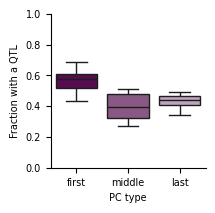

In [ ]:
fig, ax = plt.subplots(figsize=(2,2))

#sns.swarmplot(pc_cs_by_order, x='pc_order', y='has_cs', ax=ax, color='k', order=['first', 'middle', 'last'])
sns.boxplot(pc_cs_by_order, x='pc_order', y='has_cs', ax=ax, palette=sns.color_palette('light:{}_r'.format(qtl_palette['pcQTL only']), n_colors=4), order=['first', 'middle', 'last'])
ax.set_ylim([0,1])

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('PC type')
ax.set_ylabel('Fraction with a QTL')

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_pc_order_discovery.pdf", transparent=True)
plt.show()


In [ ]:
for order_1, order_2 in [['first', 'middle'], ['first', 'last'], ['middle', 'last']]:
    print('{}-{}'.format(order_1, order_2))
    print(ttest_rel(pc_cs_by_order[pc_cs_by_order['pc_order']==order_2]['has_cs'], pc_cs_by_order[pc_cs_by_order['pc_order']==order_1]['has_cs']))

first-middle
TtestResult(statistic=-6.865197382979757, pvalue=1.734416215599014e-05, df=12)
first-last
TtestResult(statistic=-11.466396331836398, pvalue=8.014127744739391e-08, df=12)
middle-last
TtestResult(statistic=1.5219774879095311, pvalue=0.15392111719290588, df=12)


### fraction discovery by if there is cross map or not

In [ ]:
pcs['has_cross_map'] = pcs['cluster_id'].isin(clusters[clusters['has_cross_map']]['cluster_id'])
pc_cs_by_cross_map = pcs.groupby(['tissue_id', 'has_cross_map']).agg({'has_cs':'mean'}).reset_index()

/local/scratch/klawren/slrmtmp.48323884/ipykernel_16676/473593937.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(pc_cs_by_cross_map, x='has_cross_map', y='has_cs',palette=['white', 'grey'], ax=ax)


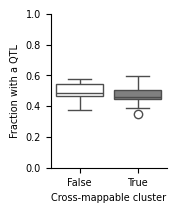

In [ ]:
fig, ax = plt.subplots(figsize=(1.5,2))

#sns.swarmplot(pc_cs_by_cross_map, x='has_cross_map', y='has_cs', ax=ax, color='k')
sns.boxplot(pc_cs_by_cross_map, x='has_cross_map', y='has_cs',palette=['white', 'grey'], ax=ax)
ax.set_ylim([0,1])

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Cross-mappable cluster')
ax.set_ylabel('Fraction with a QTL')

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_pc_cross_map_discovery.pdf", transparent=True)
plt.show()


In [ ]:
ttest_rel(pc_cs_by_cross_map[pc_cs_by_cross_map['has_cross_map']]['has_cs'], pc_cs_by_cross_map[~pc_cs_by_cross_map['has_cross_map']]['has_cs'])

TtestResult(statistic=-1.0760115519741502, pvalue=0.30307999292190996, df=12)

### pax pph4 for any pc

In [5]:
pair_coloc = load_across_tissues(config, load_pairwise_coloc)

In [ ]:
pair_coloc['qtl1_id_tissue'] = pair_coloc['qtl1_id'] + '-' + pair_coloc['tissue_id']
pair_coloc['qtl2_id_tissue'] = pair_coloc['qtl2_id'] + '-' + pair_coloc['tissue_id']

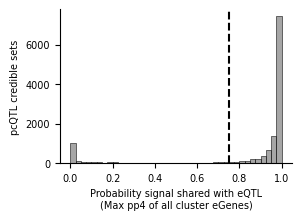

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))

pc_coloc_with_any_e = pair_coloc[(pair_coloc['qtl1_id_tissue'].str.contains('_e_'))&(pair_coloc['qtl2_id_tissue'].str.contains('_pc'))].groupby('qtl2_id_tissue').agg({'PP.H4.abf':max}).reset_index()

sns.histplot(pc_coloc_with_any_e, x='PP.H4.abf', multiple='dodge', bins=40, ax=ax,
             common_norm=False, color='grey', alpha=.7)
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('pcQTL credible sets')
ax.set_xlabel('Probability signal shared with eQTL\n(Max pp4 of all cluster eGenes)')

ax.axvline(.75, color='k', ls='--')
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_max_pph4.pdf", transparent=True)
plt.show()

### novel discoveries by pc number

In [6]:
underlying_signals = load_across_tissues(config, load_signal_groups)

In [21]:
underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')
underlying_signals_explode = underlying_signals.explode('cs_id')
underlying_signals_explode['phenotype_id_tissue'] = underlying_signals_explode['cs_id'].str.split('_cs').str[0] + '-' + underlying_signals['tissue_id']
# the ones with no e colocs
pcs['has_novel_cs'] = pcs['phenotype_id_tissue'].isin(underlying_signals_explode[underlying_signals_explode['num_e_coloc']==0]['phenotype_id_tissue'])
novel_cs_by_order = pcs.groupby(['tissue_id', 'pc_order']).agg({'has_novel_cs':'mean'}).reset_index()

/local/scratch/klawren/slrmtmp.48343185/ipykernel_50921/166711018.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pcs['has_novel_cs'] = pcs['phenotype_id_tissue'].isin(underlying_signals_explode[underlying_signals_explode['num_e_coloc']==0]['phenotype_id_tissue'])


/local/scratch/klawren/slrmtmp.48343185/ipykernel_50921/4232446828.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(novel_cs_by_order, x='pc_order', y='has_novel_cs', ax=ax, palette=sns.color_palette('light:{}_r'.format(qtl_palette['pcQTL only']), n_colors=4), order=['first', 'middle', 'last'])
/local/scratch/klawren/slrmtmp.48343185/ipykernel_50921/4232446828.py:4: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(novel_cs_by_order, x='pc_order', y='has_novel_cs', ax=ax, palette=sns.color_palette('light:{}_r'.format(qtl_palette['pcQTL only']), n_colors=4), order=['first', 'middle', 'last'])


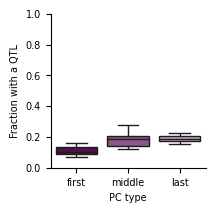

In [22]:
fig, ax = plt.subplots(figsize=(2,2))

#sns.swarmplot(novel_cs_by_order, x='pc_order', y='has_novel_cs', ax=ax, color='k', order=['first', 'middle', 'last'], s=4, alpha=.5)
sns.boxplot(novel_cs_by_order, x='pc_order', y='has_novel_cs', ax=ax, palette=sns.color_palette('light:{}_r'.format(qtl_palette['pcQTL only']), n_colors=4), order=['first', 'middle', 'last'])
ax.set_ylim([0,1])

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('PC type')
ax.set_ylabel('Fraction with a QTL')

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_novel_order_discovery.pdf", transparent=True)
plt.show()


In [23]:
for order_1, order_2 in [['first', 'middle'], ['first', 'last'], ['middle', 'last']]:
    print('{}-{}'.format(order_1, order_2))
    print(ttest_rel(novel_cs_by_order[novel_cs_by_order['pc_order']==order_2]['has_novel_cs'], novel_cs_by_order[novel_cs_by_order['pc_order']==order_1]['has_novel_cs']))

first-middle
TtestResult(statistic=6.3223493380873155, pvalue=3.8182584504702764e-05, df=12)
first-last
TtestResult(statistic=24.37486148132822, pvalue=1.3699529746837799e-11, df=12)
middle-last
TtestResult(statistic=0.836193831413932, pvalue=0.41938554642820036, df=12)


### egene effect sizes

In [24]:
# format the egene info to be a list instead of a stirng
susie_annotated = susie_annotated[~(susie_annotated['egene_id_list'] == '[nan]')]
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].apply(ast.literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].apply(ast.literal_eval)

# explode to egenes
susie_annotated_explode = susie_annotated.explode(['egene_qtl_slope', 'egene_id_list'])
susie_annotated_explode['egene_id'] = susie_annotated_explode['egene_id_list']

0         ENSG00000162687.16
0         ENSG00000000971.15
0         ENSG00000116785.13
0          ENSG00000244414.6
1         ENSG00000162687.16
                 ...        
899225     ENSG00000278311.4
899226     ENSG00000278259.4
899226     ENSG00000278311.4
899227     ENSG00000278259.4
899227     ENSG00000278311.4
Name: egene_id, Length: 2482482, dtype: object

In [25]:
# add annotation information 
def get_gene_matched_effect(row):
    gene_matched_effect = []
    for vep_effect in row['vep_info'].split(','):
        if row['egene_id'].split('.')[0] in vep_effect:
            gene_matched_effect.append(vep_effect.split('|')[1])
    return list(set(gene_matched_effect))

susie_annotated_explode['vep_info_gene'] = susie_annotated_explode.progress_apply(get_gene_matched_effect, axis=1).astype(str)
# promoter, enahncer, and ctcf are not gene specific
susie_annotated_explode['vep_CTCF'] = susie_annotated_explode['vep_info'].str.contains('CTCF_binding_site').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_enhancer'] = susie_annotated_explode['vep_info'].str.contains('enhancer').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_promoter'] = susie_annotated_explode['vep_info'].str.contains('promoter').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['qtl_in_tad'] = (susie_annotated_explode['qtl_in_tad']) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_splice'] = susie_annotated_explode['vep_info_gene'].str.contains('splice', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_nmd'] = susie_annotated_explode['vep_info_gene'].str.contains('stop_gained', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_any_effect'] = (susie_annotated_explode['vep_info_gene'].str.strip("'[],").apply(len) > 0).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['egene_qtl_slope'] = susie_annotated_explode['egene_qtl_slope'] * susie_annotated_explode['pip']

  0%|          | 0/2482482 [00:00<?, ?it/s]

In [28]:
# group into credible sets, summing over pip weighted effects
cs_grouped = susie_annotated_explode.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id' ,'egene_id']).agg(vep_any_effect=('vep_any_effect','sum'),
                                                                                                                  ctcf=('vep_CTCF','sum'),
                                                                                                                  enhancer=('vep_enhancer','sum'),
                                                                                                                  promoter=('vep_promoter','sum'),
                                                                                                                  tad=('qtl_in_tad','sum'),
                                                                                                                  splice=('vep_gene_matched_splice','sum'),
                                                                                                                  nmd=('vep_gene_matched_nmd','sum'),
                                                                                                                  egene_qtl_slope = ('egene_qtl_slope','sum'),
                                                                                                                  pip_sum=('pip','sum'),
                                                                                                                  type=('type','first'),
                                                                                                                  lead_variant_id=('lead_variant_id','first')
                                                                                                                  )

annotation_columns = cs_grouped.columns[:-3]
for c in annotation_columns:
    cs_grouped[c] = cs_grouped[c] / cs_grouped['pip_sum']
cs_grouped = cs_grouped.reset_index()
# get an idx column
cs_grouped = cs_grouped.reset_index()

# add distance between gene and lead variant
cs_grouped['gene_start'] = cs_grouped['egene_id'].map(tss_dict)

cs_grouped['lead_variant_position'] = cs_grouped['lead_variant_id'].str.split('_').str[1].astype(int)
cs_grouped['distance'] = (cs_grouped['gene_start'] - cs_grouped['lead_variant_position']).apply(abs) + 1
cs_grouped['log_distance'] = np.log10(cs_grouped['distance'])

# add beta squared
cs_grouped['egene_beta_squared'] = cs_grouped['egene_qtl_slope']**2

# add in underlying signal info 
underlying_signals['exclusive_label'] = np.where((underlying_signals['num_e_coloc'] > 0), np.where((underlying_signals['num_pc_coloc'] > 0), 'Both', 'eQTL only'), 'pcQTL only')
cs_grouped = pd.merge(cs_grouped, underlying_signals.explode(['cs_id'])[['tissue_id', 'cs_id', 'exclusive_label', 'signal_id']], on=['tissue_id', 'cs_id']).reset_index()
cs_grouped['gene_strand'] = cs_grouped['egene_id'].map(strand_dict)


In [ ]:
# top two effect egenes
cs_grouped_sorted = cs_grouped.sort_values(['tissue_id', 'phenotype_id', 'cs_id', 'egene_beta_squared'],ascending=[True, True, True, False])

# largest effect egene
first_effect_cs_grouped = cs_grouped_sorted.groupby(['tissue_id', 'phenotype_id', 'cs_id']).first()

# add in the sums of all egene betas
beta_squared_sums = cs_grouped_sorted.groupby(['tissue_id', 'phenotype_id', 'cs_id']).agg(egene_beta_squared_sum=('egene_beta_squared','sum'))
first_effect_cs_grouped = pd.merge(first_effect_cs_grouped, beta_squared_sums, on=['tissue_id', 'phenotype_id', 'cs_id']).reset_index()

# second largest effect egene
second_effect_cs_grouped = cs_grouped_sorted[~cs_grouped_sorted['index'].isin(first_effect_cs_grouped['index'])].groupby(['tissue_id', 'phenotype_id', 'cs_id']).first().reset_index()

# group into one df
two_effect_cs_grouped = pd.merge(first_effect_cs_grouped, second_effect_cs_grouped[['tissue_id', 'phenotype_id', 'cs_id', 'distance', 'log_distance', 'egene_qtl_slope', 'egene_beta_squared', 'gene_strand', 'gene_start']], on=['tissue_id', 'phenotype_id', 'cs_id'], suffixes=['_first', '_second'])
two_effect_cs_grouped = two_effect_cs_grouped[two_effect_cs_grouped['egene_qtl_slope_first']!=0]
two_effect_cs_grouped['egene_beta_squared_first_frac'] = two_effect_cs_grouped['egene_beta_squared_first']/(two_effect_cs_grouped['egene_beta_squared_sum'])

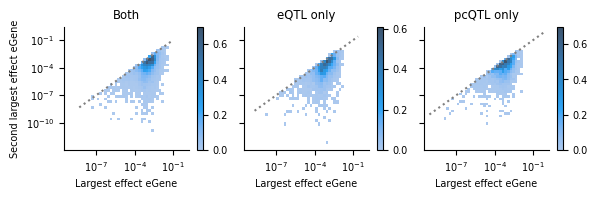

In [31]:
g=sns.FacetGrid(two_effect_cs_grouped.groupby('signal_id').first(), col='exclusive_label', aspect=1, height=2)
g.map(sns.histplot, 'egene_beta_squared_first',  'egene_beta_squared_second', bins=30, log_scale=(True, True), cbar=True, stat='density')

for ax in g.axes.flat:
    ax.plot(ax.get_xlim(), ax.get_xlim(), color = 'grey', ls=':')
    ax.set_xlabel('Largest effect eGene')

g.axes.flat[0].set_ylabel('Second largest effect eGene')
g.axes.flat[0].set_title('Both')
g.axes.flat[1].set_title('eQTL only')
g.axes.flat[2].set_title('pcQTL only')

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_egene_scatterplot.pdf", transparent=True)
plt.show()


### egene effect size vs distance to lead varaint 

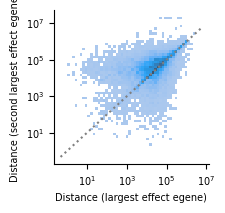

In [32]:
fig, ax = plt.subplots(figsize=(2,2))

sns.histplot(two_effect_cs_grouped, x='distance_first', y='distance_second', bins=50, ax=ax, log_scale=True)
ax.plot(ax.get_xlim(), ax.get_xlim(), color = 'grey', ls=':')

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Distance (largest effect egene)')
ax.set_ylabel('Distance (second largest effect egene)')
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_egene_dist.pdf", transparent=True)
plt.show()

In [36]:
sum((two_effect_cs_grouped['distance_first'] < two_effect_cs_grouped['distance_second']))/len(two_effect_cs_grouped) * 100

65.96123738055391

### diffuse effect annotation enrichments

In [37]:
# group over egenes
egene_grouped = cs_grouped.groupby(['tissue_id', 'cs_id', 'signal_id']).agg(vep_single_gene=('vep_any_effect',lambda values: (sorted(values, reverse=True)[0]>0) & (sorted(values, reverse=True)[1]==0)), 
                                                             vep_multi_gene=('vep_any_effect',lambda values: sorted(values, reverse=True)[1]>0), 
                                                             ctcf=('ctcf',lambda values: max(values)>0), 
                                                             enhancer=('enhancer',lambda values: max(values)>0), 
                                                             vep_promoter=('promoter',lambda values: max(values)>0), 
                                                             dist_promoter=('distance',lambda values: sum([d < 1000 for d in values])>0), 
                                                             dist_multi_promoter=('distance',lambda values: sum([d < 1000 for d in values])-1>0), 
                                                             list_promoter=('promoter', list),
                                                             tad=('tad',lambda values: max(values)>0), 
                                                             splice=('splice',lambda values: max(values)>0), 
                                                             nmd=('nmd',lambda values: max(values)>0),
                                                             exclusive_label=('exclusive_label', 'first'), 
                                                             max_egene_beta_squared=('egene_beta_squared', 'max'), 
                                                             sum_egene_beta_squared=('egene_beta_squared', 'sum'), 
                                                             cluster_id=('cluster_id','first'))

egene_grouped = egene_grouped[egene_grouped['sum_egene_beta_squared']!=0]
egene_grouped['frac_egene_beta_squared'] = egene_grouped['max_egene_beta_squared']/egene_grouped['sum_egene_beta_squared']
egene_grouped['cluster_size'] = egene_grouped['cluster_id'].str.split('_').apply(len)

In [38]:
# group by signal ids
signal_grouped = egene_grouped.groupby(['tissue_id', 'signal_id']).agg(vep_single_gene=('vep_single_gene','min'), 
                                                             vep_multi_gene=('vep_multi_gene','max'), 
                                                             ctcf=('ctcf','max'), 
                                                             enhancer=('enhancer','max'), 
                                                             vep_promoter=('vep_promoter','max'),
                                                             dist_promoter=('dist_promoter','max'),
                                                             dist_multi_promoter=('dist_multi_promoter','max'),
                                                             tad=('tad','max'), 
                                                             splice=('splice','max'), 
                                                             nmd=('nmd','max'),
                                                             exclusive_label=('exclusive_label', 'first'), 
                                                             max_egene_beta_squared=('max_egene_beta_squared', 'mean'), 
                                                             sum_egene_beta_squared=('sum_egene_beta_squared', 'mean'), 
                                                             frac_egene_beta_squared=('frac_egene_beta_squared', 'mean'), 
                                                             cluster_size=('cluster_size','first'))

In [71]:
signal_grouped['frac_egene_beta_squared'].median()

0.8030397652386319

In [79]:
column_list = ['vep_multi_gene', 'vep_single_gene', 'dist_multi_promoter', 'enhancer', 'tad', 'ctcf',  'dist_promoter', 'splice', 'nmd']

signal_grouped['frac_bool'] = signal_grouped['frac_egene_beta_squared'] < .8
or_frac = get_odds_df(signal_grouped, label_col='frac_bool', column_list=column_list[::-1], correct_on=True, correct_on_column='cluster_size').reset_index()

nmd
Optimization terminated successfully.
         Current function value: 0.665844
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                20747
Model:                          Logit   Df Residuals:                    20744
Method:                           MLE   Df Model:                            2
Date:                Thu, 05 Jun 2025   Pseudo R-squ.:                 0.03934
Time:                        11:46:31   Log-Likelihood:                -13814.
converged:                       True   LL-Null:                       -14380.
Covariance Type:            nonrobust   LLR p-value:                2.185e-246
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.4489      0.052    -28.057      0.000      -1.550      -1.348
cluster_size     0.

/local/scratch/klawren/slrmtmp.48343185/ipykernel_50921/320491968.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['VEP effect on multiple genes', 'VEP effect single gene', 'shared promoter', 'enhancer', 'TAD boundary', 'CTCF', 'promoter', 'splice site', 'stop-gain'][::-1])


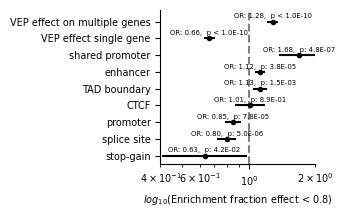

In [80]:
fig, ax = plt.subplots(figsize=(2,2))
ax.errorbar(y=or_frac['col'], x=or_frac['odds_ratio'], xerr=np.clip(or_frac[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), -3, 3), fmt=".", color='k')
# add line at 0
ax.axvline(1, color='grey', linestyle='--')
# add annotations
for idx, row in or_frac.iterrows():
    if row['p_value'] < 1e-10:
        ax.annotate('OR: {:.2f},  p < {:.1E}'.format(row['odds_ratio'], 1e-10), (row['odds_ratio'], idx+.2), fontsize=5, ha='center')
    else:
        ax.annotate('OR: {:.2f},  p: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2), fontsize=5, ha='center')

# give some more space on the y axis
ax.set_ylim((ax.get_ylim()[0]-.1, ax.get_ylim()[1]+.3))
ax.set_yticklabels(['VEP effect on multiple genes', 'VEP effect single gene', 'shared promoter', 'enhancer', 'TAD boundary', 'CTCF', 'promoter', 'splice site', 'stop-gain'][::-1])

# format the x axis
ax.set_xlabel(r'$log_{10}$(Enrichment fraction effect < 0.8)')
ax.set_xscale('log')
ax.set_xlim([.4, 2])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_frac_enrichments.pdf", transparent=True)
plt.show()

#### CLUAP1 and NLRC3 example

In [ ]:
# load in gwas data
gwas_coloc = load_gwas_coloc(config)
pair_coloc = load_across_tissues(config, load_pairwise_coloc)
coloc_cutoff=0.75

gwas_coloc_hits = gwas_coloc[gwas_coloc['PP.H4.abf'] > coloc_cutoff].reset_index()
pair_coloc_hits = pair_coloc[pair_coloc['PP.H4.abf'] > coloc_cutoff].reset_index()
underlying_gwas_signals = get_gwas_signals(gwas_coloc_hits, pair_coloc_hits)

File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.EGG_Pubertal_growth_10F.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.GEFOS_Forearm.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.UKB_G43_Diagnoses_main_ICD10_G43_Migraine.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.GPC-NEO-NEUROTICISM.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.PGC_ASD_2017_CEU.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/

/home/klawren/oak/pcqtls/workflow/scripts/notebook_helper_functions.py:539: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals_explode_gwas['gwas_type'] = underlying_signals_explode_gwas['cs_id'].str.split('gwas_').str[1].str.split('_cs').str[0]


In [6]:
example_cs_id = 'ENSG00000103351.12_ENSG00000167984.17_pc2_cs_1'
example_cluster_id = 'ENSG00000103351.12_ENSG00000167984.17'
example_tissue_id = 'Adipose_Subcutaneous'
example_chr_id = 16

example_cs = susie_annotated[(susie_annotated['cs_id']==example_cs_id) & (susie_annotated['tissue_id']==example_tissue_id) ]

/local/scratch/klawren/slrmtmp.48343185/ipykernel_21200/1534586353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_gwas_pairs['id1_short'] = np.where(cluster_gwas_pairs['qtl_id'].str.contains('_e_'), cluster_gwas_pairs['qtl_id'].str.split('_e_').str[-1], 'PC' + cluster_gwas_pairs['qtl_id'].str.split('_pc').str[-1])
/local/scratch/klawren/slrmtmp.48343185/ipykernel_21200/1534586353.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_gwas_pairs['id2_short'] = cluster_gwas_pairs['gwas_tissu

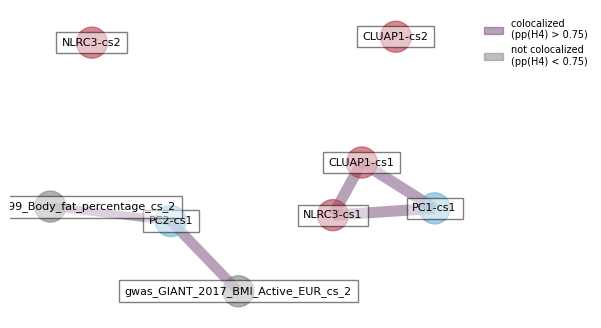

In [ ]:
# cluster coloc graph

# get the gwas-qtl coloc pairs
cluster_gwas_pairs = gwas_coloc[(gwas_coloc['cluster_id'] == example_cluster_id) & (gwas_coloc['tissue_id'] == example_tissue_id)]
cluster_gwas_pairs['id1_short'] = np.where(cluster_gwas_pairs['qtl_id'].str.contains('_e_'), cluster_gwas_pairs['qtl_id'].str.split('_e_').str[-1], 'PC' + cluster_gwas_pairs['qtl_id'].str.split('_pc').str[-1])
cluster_gwas_pairs['id2_short'] = cluster_gwas_pairs['gwas_tissue_cs_id'].str.split('_cluster').str[0]
cluster_gwas_pairs['id1_short'] = cluster_gwas_pairs['id1_short'].apply(get_gene_name) + '-cs' + cluster_gwas_pairs['qtl_cs_is'].astype(int).astype(str)
# drop out GWAS that don't coloc with anything
gwas_max_pph4 = cluster_gwas_pairs.groupby('gwas_tissue_cs_id').agg({'PP.H4.abf':'max'})
cluster_gwas_pairs = cluster_gwas_pairs[cluster_gwas_pairs['gwas_tissue_cs_id'].isin(gwas_max_pph4[gwas_max_pph4['PP.H4.abf'] > coloc_cutoff].index.values)]

# load in the pair qlt-qtl colocs too
pair_coloc_qtl = load_pairwise_coloc(config, example_tissue_id)
pair_coloc_qtl['cluster_id'] = pair_coloc_qtl['qtl1_id'].str.split('_e_').str[0].str.split('_pc').str[0]
cluster_pairs_qtl = pair_coloc_qtl[pair_coloc_qtl['cluster_id'] == example_cluster_id]
cluster_pairs_qtl['id1_short'] = np.where(cluster_pairs_qtl['qtl1_id'].str.contains('_e_'), cluster_pairs_qtl['qtl1_id'].str.split('_e_').str[-1], 'PC' + cluster_pairs_qtl['qtl1_id'].str.split('_pc').str[-1])
cluster_pairs_qtl['id2_short'] = np.where(cluster_pairs_qtl['qtl2_id'].str.contains('_e_'), cluster_pairs_qtl['qtl2_id'].str.split('_e_').str[-1], 'PC' + cluster_pairs_qtl['qtl2_id'].str.split('_pc').str[-1])
cluster_pairs_qtl['id1_short'] = cluster_pairs_qtl['id1_short'].apply(get_gene_name) + '-cs' + cluster_pairs_qtl['idx1'].astype(str)
cluster_pairs_qtl['id2_short'] = cluster_pairs_qtl['id2_short'].apply(get_gene_name)+ '-cs' + cluster_pairs_qtl['idx2'].astype(str)

# Create an undirected graph
G = nx.Graph()

# Add edges to the graph with weights
for index, row in pd.concat([cluster_pairs_qtl, cluster_gwas_pairs]).iterrows():
    G.add_edge(row['id1_short'], row['id2_short'], weight=row['PP.H4.abf'])

# Get edge weights for thickness
edge_weights = [G[u][v]['weight']*8 for u, v in G.edges()]
edge_colors = ['#734675' if G[u][v]['weight'] > 0.75 else 'gray' for u, v in G.edges()]
node_colors = ['#808080' if 'gwas' in node else '#67AFD2' if 'PC' in node else '#B83A4B' for node in G.nodes()]

fig, ax = plt.subplots(figsize=(6, 4)) 

pos = nx.spring_layout(G, k=1)  
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.6, ax=ax)
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors, alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, bbox= dict(facecolor='white', alpha=0.5, edgecolor='k'))
ax.axis('off')  # Turn off the axis

# Create legend
purple_patch = mpatches.Patch(color='#734675', alpha=0.5, label='colocalized \n(pp(H4) > 0.75)')
gray_patch = mpatches.Patch(color='gray', alpha=0.5, label='not colocalized \n(pp(H4) < 0.75)')
ax.legend(handles=[purple_patch, gray_patch], loc='upper right', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
cluster_gwas_pairs

,gwas_id,qtl_id,nsnps,hit1,hit2,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,...,coloc_file,cluster_id,gwas_cs_id,qtl_cs_id,type,gwas_tissue_cs_id,qtl_tissue_cs_id,id1_short,id2_short,is_pc
635085,UKB_23099_Body_fat_percentage,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,4033.0,chr16_3658566_G_A_b38,chr16_3606556_G_A_b38,1.577250e-06,7.832732e-04,0.002006,0.996195,0.001014,...,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000103351.12_ENSG00000167984.17,UKB_23099_Body_fat_percentage_cs_2_cluster_ENS...,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,eqtl,gwas_UKB_23099_Body_fat_percentage_cs_2_cluste...,qtl_ENSG00000103351.12_ENSG00000167984.17_e_EN...,CLUAP1-cs2,gwas_UKB_23099_Body_fat_percentage_cs_2,False
635088,UKB_23099_Body_fat_percentage,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,4033.0,chr16_3658566_G_A_b38,chr16_3538166_T_G_b38,1.515670e-06,7.526924e-04,0.002008,0.997169,0.000069,...,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000103351.12_ENSG00000167984.17,UKB_23099_Body_fat_percentage_cs_2_cluster_ENS...,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,eqtl,gwas_UKB_23099_Body_fat_percentage_cs_2_cluste...,qtl_ENSG00000103351.12_ENSG00000167984.17_e_EN...,NLRC3-cs2,gwas_UKB_23099_Body_fat_percentage_cs_2,False
635091,UKB_23099_Body_fat_percentage,ENSG00000103351.12_ENSG00000167984.17_pc1,4033.0,chr16_3658566_G_A_b38,chr16_3539024_AC_A_b38,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000103351.12_ENSG00000167984.17,UKB_23099_Body_fat_percentage_cs_2_cluster_ENS...,ENSG00000103351.12_ENSG00000167984.17_pc1_cs_1...,pcqtl,gwas_UKB_23099_Body_fat_percentage_cs_2_cluste...,qtl_ENSG00000103351.12_ENSG00000167984.17_pc1_...,PC1-cs1,gwas_UKB_23099_Body_fat_percentage_cs_2,True
635094,UKB_23099_Body_fat_percentage,ENSG00000103351.12_ENSG00000167984.17_pc2,4033.0,chr16_3658566_G_A_b38,chr16_3516362_G_A_b38,2.985938e-11,1.482838e-08,0.000503,0.248192,0.751305,...,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000103351.12_ENSG00000167984.17,UKB_23099_Body_fat_percentage_cs_2_cluster_ENS...,ENSG00000103351.12_ENSG00000167984.17_pc2_cs_1...,pcqtl,gwas_UKB_23099_Body_fat_percentage_cs_2_cluste...,qtl_ENSG00000103351.12_ENSG00000167984.17_pc2_...,PC2-cs1,gwas_UKB_23099_Body_fat_percentage_cs_2,True
636049,GIANT_2017_BMI_Active_EUR,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,911.0,chr16_3696240_C_T_b38,chr16_3539024_AC_A_b38,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000103351.12_ENSG00000167984.17,GIANT_2017_BMI_Active_EUR_cs_2_cluster_ENSG000...,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,eqtl,gwas_GIANT_2017_BMI_Active_EUR_cs_2_cluster_EN...,qtl_ENSG00000103351.12_ENSG00000167984.17_e_EN...,CLUAP1-cs1,gwas_GIANT_2017_BMI_Active_EUR_cs_2,False
636051,GIANT_2017_BMI_Active_EUR,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,911.0,chr16_3696240_C_T_b38,chr16_3606556_G_A_b38,-2.220446e-16,0.000000e+00,0.000000,0.000000,0.000000,...,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000103351.12_ENSG00000167984.17,GIANT_2017_BMI_Active_EUR_cs_2_cluster_ENSG000...,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,eqtl,gwas_GIANT_2017_BMI_Active_EUR_cs_2_cluster_EN...,qtl_ENSG00000103351.12_ENSG00000167984.17_e_EN...,CLUAP1-cs2,gwas_GIANT_2017_BMI_Active_EUR_cs_2,False
636053,GIANT_2017_BMI_Active_EUR,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,911.0,chr16_3696240_C_T_b38,chr16_3539024_AC_A_b38,-2.442491e-15,0.000000e+00,0.000000,0.000000,0.000000,...,/home/klawren/oak/pcqtls/output/proteincoding_...,ENSG00000103351.12_ENSG00000167984.17,GIANT_2017_BMI_Active_EUR_cs_2_cluster_ENSG000...,ENSG00000103351.12_ENSG00000167984.17_e_ENSG00...,eqtl,gwas_GIANT_2017_BMI_Active_EUR_cs_2_cluster_EN...,qtl_ENSG00000103351.12_ENSG00000167984.17_e_EN...,NLRC3-cs1,gwas_GIANT_2017_BMI_Active_EUR_cs_2,False
636055,GIANT_2017_BMI_Active_EUR,ENS

In [ ]:
# bring in the nominal p values
nominal_e = load_e_nominal(config, example_tissue_id, example_chr_id)
nominal_pc = load_pc_nominal(config, example_tissue_id, example_chr_id)

In [ ]:
# bring in gwas summary stats
gwas_path = '/oak/stanford/groups/smontgom/shared/gwas_summary_stats/barbeira_gtex_imputed/imputed_gwas_hg38_1.1/imputed_UKB_23099_Body_fat_percentage.txt.gz'
example_gwas = pd.read_csv(gwas_path, sep='\t')

ENSG00000103351.12_ENSG00000167984.17_e_ENSG00000103351.12_cs_1


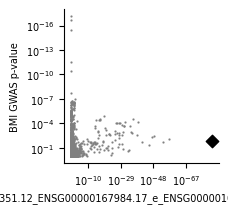

ENSG00000103351.12_ENSG00000167984.17_e_ENSG00000103351.12_cs_2


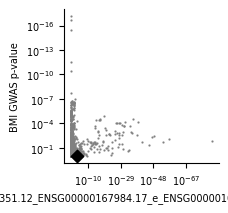

ENSG00000103351.12_ENSG00000167984.17_e_ENSG00000167984.17_cs_1


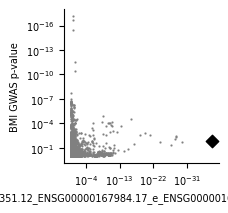

ENSG00000103351.12_ENSG00000167984.17_e_ENSG00000167984.17_cs_2


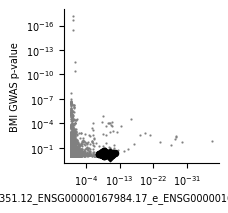

ENSG00000103351.12_ENSG00000167984.17_pc1_cs_1


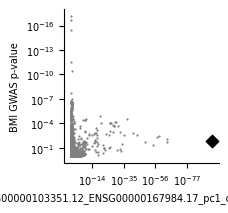

ENSG00000103351.12_ENSG00000167984.17_pc2_cs_1


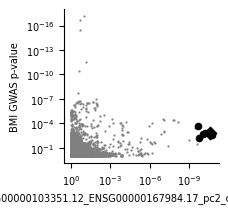

In [ ]:
# make a coloc plot for each credible set. highlihgt lead vars from that creible set

all_example_cs = susie_annotated[(susie_annotated['cluster_id']==example_cluster_id) & (susie_annotated['tissue_id']==example_tissue_id)]
for cs_id, this_cs in all_example_cs.groupby('cs_id'):
    print(cs_id)
    phenotype_id = this_cs['phenotype_id'].iloc[0]
    if '_pc' in phenotype_id:
        this_cs_pvalues = nominal_pc[(nominal_pc['cluster_id'] == example_cluster_id) & (nominal_pc['phenotype_id']==this_cs['phenotype_id'].iloc[0])][['variant_id', 'pval_nominal']]
    else:
        this_cs_pvalues = nominal_e[(nominal_e['cluster_id'] == example_cluster_id) & (nominal_e['phenotype_id']==this_cs['phenotype_id'].iloc[0])][['variant_id', 'pval_nominal']]
    gwas_cs_pvalues_merged = pd.merge(this_cs_pvalues, example_gwas[['panel_variant_id', 'pvalue']], left_on='variant_id', right_on='panel_variant_id', how='inner')
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.scatterplot(gwas_cs_pvalues_merged, x='pval_nominal', y='pvalue', s=2, alpha=1, edgecolor=None, ax=ax, color='grey')
    sns.scatterplot(gwas_cs_pvalues_merged[gwas_cs_pvalues_merged['variant_id'].isin(this_cs['variant_id'])], x='pval_nominal', y='pvalue', s=20, alpha=1, linewidth=1, edgecolor='k', ax=ax, color='k')
    sns.scatterplot(gwas_cs_pvalues_merged[gwas_cs_pvalues_merged['variant_id'].isin(this_cs['lead_variant_id'])], x='pval_nominal', y='pvalue', s=40, alpha=1, linewidth=1, edgecolor='k', ax=ax, color='k', marker='D')

    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(f'{cs_id} QTL p-value')
    ax.set_ylabel('BMI GWAS p-value')
    # ax.set_xticks([1e0, 1e-4, 1e-8])
    # ax.set_yticks([1e0, 1e-6, 1e-12])
    plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_example_2_coloc_2_{cs_id}.pdf", transparent=True)

    plt.show()


In [ ]:
# bring in gwas summary stats
gwas_path = '/oak/stanford/groups/smontgom/shared/gwas_summary_stats/barbeira_gtex_imputed/imputed_gwas_hg38_1.1/imputed_GIANT_2017_BMI_Active_EUR.txt.gz'
example_gwas = pd.read_csv(gwas_path, sep='\t')

ENSG00000103351.12_ENSG00000167984.17_e_ENSG00000103351.12_cs_1


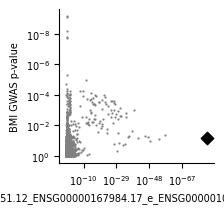

ENSG00000103351.12_ENSG00000167984.17_e_ENSG00000103351.12_cs_2


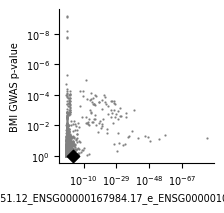

ENSG00000103351.12_ENSG00000167984.17_e_ENSG00000167984.17_cs_1


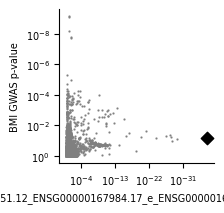

ENSG00000103351.12_ENSG00000167984.17_e_ENSG00000167984.17_cs_2


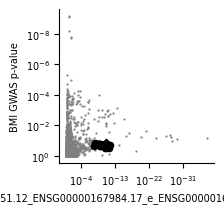

ENSG00000103351.12_ENSG00000167984.17_pc1_cs_1


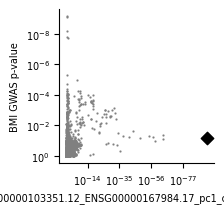

ENSG00000103351.12_ENSG00000167984.17_pc2_cs_1


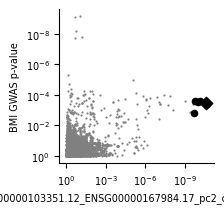

In [ ]:
# make a coloc plot for each credible set. highlihgt lead vars from that creible set

all_example_cs = susie_annotated[(susie_annotated['cluster_id']==example_cluster_id) & (susie_annotated['tissue_id']==example_tissue_id)]
for cs_id, this_cs in all_example_cs.groupby('cs_id'):
    print(cs_id)
    phenotype_id = this_cs['phenotype_id'].iloc[0]
    if '_pc' in phenotype_id:
        this_cs_pvalues = nominal_pc[(nominal_pc['cluster_id'] == example_cluster_id) & (nominal_pc['phenotype_id']==this_cs['phenotype_id'].iloc[0])][['variant_id', 'pval_nominal']]
    else:
        this_cs_pvalues = nominal_e[(nominal_e['cluster_id'] == example_cluster_id) & (nominal_e['phenotype_id']==this_cs['phenotype_id'].iloc[0])][['variant_id', 'pval_nominal']]
    gwas_cs_pvalues_merged = pd.merge(this_cs_pvalues, example_gwas[['panel_variant_id', 'pvalue']], left_on='variant_id', right_on='panel_variant_id', how='inner')
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.scatterplot(gwas_cs_pvalues_merged, x='pval_nominal', y='pvalue', s=2, alpha=1, edgecolor=None, ax=ax, color='grey')
    sns.scatterplot(gwas_cs_pvalues_merged[gwas_cs_pvalues_merged['variant_id'].isin(this_cs['variant_id'])], x='pval_nominal', y='pvalue', s=20, alpha=1, linewidth=1, edgecolor='k', ax=ax, color='k')
    sns.scatterplot(gwas_cs_pvalues_merged[gwas_cs_pvalues_merged['variant_id'].isin(this_cs['lead_variant_id'])], x='pval_nominal', y='pvalue', s=40, alpha=1, linewidth=1, edgecolor='k', ax=ax, color='k', marker='D')

    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(f'{cs_id} QTL p-value')
    ax.set_ylabel('BMI GWAS p-value')
    # ax.set_xticks([1e0, 1e-4, 1e-8])
    # ax.set_yticks([1e0, 1e-6, 1e-12])
    plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_example_2_coloc_{cs_id}.pdf", transparent=True)

    plt.show()


### expression corr

In [7]:
# load in expression
expression = load_cluster_expression(config, 'Adipose_Subcutaneous')
cluster_expresison = expression[expression['cluster_id']==example_cluster_id]
sample_columns = cluster_expresison.columns[cluster_expresison.columns.str.contains('GTEX')]
cluster_expression_pivot = cluster_expresison[sample_columns].T
cluster_expression_pivot.columns = cluster_expresison['egene_id']

pcs = load_pc(config, 'Adipose_Subcutaneous')
cluster_pcs = pcs[pcs['cluster_id']==example_cluster_id]
cluster_pcs_pivot = cluster_pcs[sample_columns].T
cluster_pcs_pivot.columns = ['pc1', 'pc2']

# get the genotypes
# with something like "bcftools view -r chr16:3516362 "$vcf_file" | tail -n 2 > chr16.3516362.genotype.txt"
genotypes = pd.read_csv('/home/klawren/oak/pcqtls/data/processed/genotypes/chr16.3516362.genotype.txt', sep='\t')
cluster_expression_pivot['genotype'] = genotypes[sample_columns].T
cluster_expression_pivot['genotype_collapsed'] = cluster_expression_pivot['genotype'].str.count('1')

# get the correlations
correlation_results = cluster_expression_pivot.groupby('genotype_collapsed').apply(
    lambda group: spearmanr(group['ENSG00000103351.12'], group['ENSG00000167984.17']))

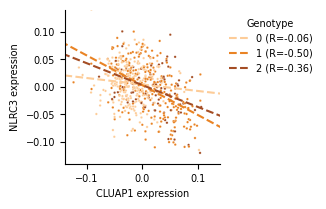

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))

sns.scatterplot(data=cluster_expression_pivot, 
                x='ENSG00000103351.12', 
                y='ENSG00000167984.17', 
                hue='genotype_collapsed', s=3, palette=genotype_palette, legend=False, ax=ax)

for genotype in [0,1,2]:
    subset = cluster_expression_pivot[cluster_expression_pivot['genotype_collapsed'] == genotype]

    X = sm.add_constant(subset['ENSG00000103351.12'])  # Add a constant for the intercept
    model = sm.OLS(subset['ENSG00000167984.17'], X).fit()
    x_vals = np.linspace(-.2, .2, 100)
    y_vals = model.predict(sm.add_constant(x_vals))
    
    # Plot the regression line
    ax.plot(x_vals, y_vals, label='{} (R={:.2f})'.format(genotype, correlation_results[genotype][0]), color=genotype_palette[genotype], ls='--')

# Customize the plot
plt.legend(title='Genotype')
plt.xlim(-.14, .14)
plt.ylim(-.14, .14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='Genotype')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('CLUAP1 expression')
ax.set_ylabel('NLRC3 expression')
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_supp_example_2_corr.pdf", transparent=True)

plt.show()

In [57]:
# Extract the correlation coefficients and sample sizes
r1 = correlation_results.loc[0][0]  # Correlation for the first genotype
r2 = correlation_results.loc[2][0]  # Correlation for the second genotype
n1 = cluster_expression_pivot[cluster_expression_pivot['genotype_collapsed'] == correlation_results.index[0]].shape[0]
n2 = cluster_expression_pivot[cluster_expression_pivot['genotype_collapsed'] == correlation_results.index[1]].shape[0]

# Fisher's z-transformation
def fisher_z(r):
    return 0.5 * np.log((1 + r) / (1 - r))

z1 = fisher_z(r1)
z2 = fisher_z(r2)

# Standard error for the difference between two correlations
SE = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))

# Calculate the z-score for the difference
z_score = (z1 - z2) / SE

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # Two-tailed test

# Output results
print(f"Correlation for group 1: {r1}, Sample size: {n1}")
print(f"Correlation for group 2: {r2}, Sample size: {n2}")
print(f"Z-score: {z_score}, P-value: {p_value}")

# Check if each correlation is significantly different from zero
p_value_r1 = 2 * (1 - norm.cdf(abs(fisher_z(r1) / np.sqrt(1/(n1 - 2)))))
p_value_r2 = 2 * (1 - norm.cdf(abs(fisher_z(r2) / np.sqrt(1/(n2 - 2)))))

print(f"P-value for correlation in group 1: {p_value_r1}")
print(f"P-value for correlation in group 2: {p_value_r2}")

Correlation for group 1: -0.06344584607285318, Sample size: 261
Correlation for group 2: -0.36190391886594414, Sample size: 242
Z-score: 3.5147167563967403, P-value: 0.00044022324807513336
P-value for correlation in group 1: 0.30657381570671793
P-value for correlation in group 2: 4.289993027484229e-09
